In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sys
sys.path.append('../../../../infrastructure/tools')
from utilities import *
from plotting import *
import pickle
from sklearn.mixture import GaussianMixture

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [3]:
cards = pd.read_csv("../../../data/intermediate/cards.csv")

In [4]:
cards.columns.tolist()

['card_id',
 'user_id',
 'card_brand',
 'card_type',
 'card_number',
 'expires',
 'cvv',
 'has_chip',
 'num_cards_issued',
 'credit_limit',
 'acct_open_date',
 'year_pin_last_changed',
 'card_on_dark_web',
 'current_age',
 'retirement_age',
 'birth_year',
 'birth_month',
 'gender',
 'address',
 'latitude',
 'longitude',
 'per_capita_income',
 'yearly_income',
 'total_debt',
 'credit_score',
 'num_credit_cards']

In [5]:
cards.shape

(6146, 26)

In [6]:
for var in ['per_capita_income','yearly_income','total_debt','credit_limit']:
    cards[var] = cards[var].apply(lambda x: float(x.replace("$", "")))

In [9]:
cards['card_on_dark_web'] = cards['card_on_dark_web'].apply(lambda x: 1 if x.lower() == 'yes' else (0 if x.lower() == 'no' else x))

In [10]:
user_attr = [
'user_id', 
'current_age',
'retirement_age',
'birth_year',
'birth_month',
'gender',
'address',
'latitude',
'longitude',
'per_capita_income',
'yearly_income',
'total_debt',
'credit_score',
'num_credit_cards']

In [11]:
user_info = cards[user_attr].drop_duplicates().reset_index(drop=True)

In [12]:
# cards.card_on_dark_web = cards.card_on_dark_web.astype('int')

In [13]:
user_info_agg = utilities.pivot(cards, varlist = {'credit_limit':'sum','card_on_dark_web':'sum'}, by_vars = ['user_id'])

In [14]:
user_info = user_info.merge(user_info_agg, on='user_id')

In [13]:
user_info

,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,count,sum_credit_limit,sum_card_on_dark_web
0,0,33,69,1986,3,Male,858 Plum Avenue,43.59,-70.33,29237.0,59613.0,36199.0,763,4,4,105656.0,0
1,1,43,74,1976,4,Female,113 Burns Lane,30.44,-87.18,22247.0,45360.0,14587.0,704,3,3,41805.0,0
2,2,48,64,1971,8,Male,6035 Forest Avenue,40.84,-73.87,13461.0,27447.0,80850.0,673,5,5,50361.0,0
3,3,49,65,1970,12,Male,840 Elm Avenue,33.89,-98.51,13705.0,27943.0,18693.0,681,4,4,13722.0,0
4,4,54,72,1965,3,Female,6016 Little Creek Boulevard,47.61,-122.30,37485.0,76431.0,115362.0,716,5,5,136202.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,64,62,1955,7,Female,28 First Lane,39.92,-77.71,20943.0,39206.0,9219.0,605,4,4,30965.0,0
1996,1996,46,66,1973,6,Female,7853 Grant Street,29.43,-95.24,21956.0,44768.0,59862.0,728,3,3,47175.0,0
1997,1997,76,69,1943,8,Male,765 Forest Street,44.92,-93.40,39155.0,38800.0,25867.0,758,7,7,142669.0,0
1998,1998,65,67,1954,9,Male,10 Third Avenue,37.56,-122.37,0.0,645.0,790.0,688,3,3,538.0,0


In [14]:
user_info['dti'] = user_info.total_debt/user_info.yearly_income

In [15]:
user_info['income_to_median'] = np.minimum(user_info.yearly_income/user_info.per_capita_income, 10)

<Axes: >

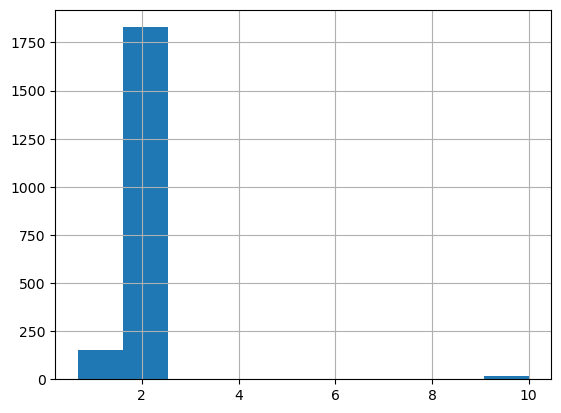

In [16]:
user_info['income_to_median'].hist()

<Axes: >

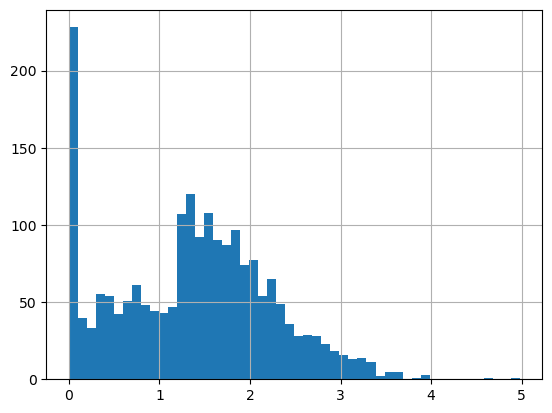

In [36]:
user_info['dti'].hist(bins=50)

In [18]:
plotting.px_scatter_plot(user_info, x_var='latitude', y_var='longitude', show=False, width=1000, height=800)

<Axes: >

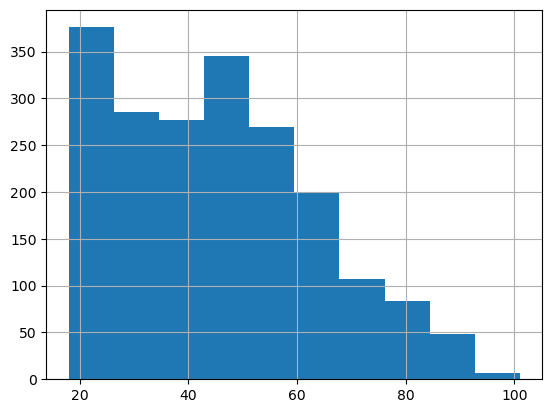

In [19]:
user_info.current_age.hist()

<Axes: >

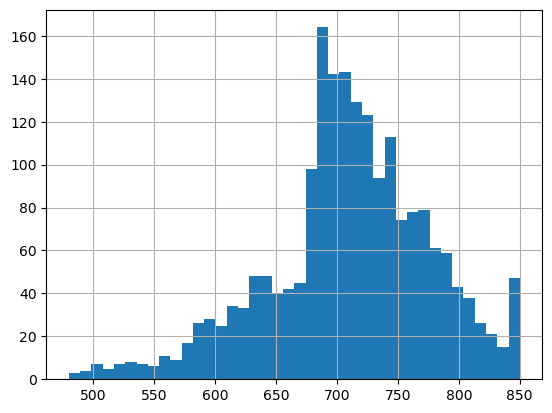

In [38]:
user_info.credit_score.hist(bins=40)

In [21]:
cluster_vars = ['latitude', 'longitude']

In [22]:
# cluster_vars = ['credit_score','latitude', 'longitude','dti','current_age']

In [23]:
# scaler = MinMaxScaler(feature_range=(0, 1)) 
# scaled_data = scaler.fit_transform(user_info[cluster_vars])

In [26]:
inertia = []
models = []
max_cluster = 30
for i in range(2,max_cluster):
    kmeans = KMeans(init="k-means++",n_clusters=i, random_state=0).fit(user_info[cluster_vars])
    inertia.append(kmeans.inertia_)
    models.append(kmeans)

Text(0, 0.5, 'inertia')

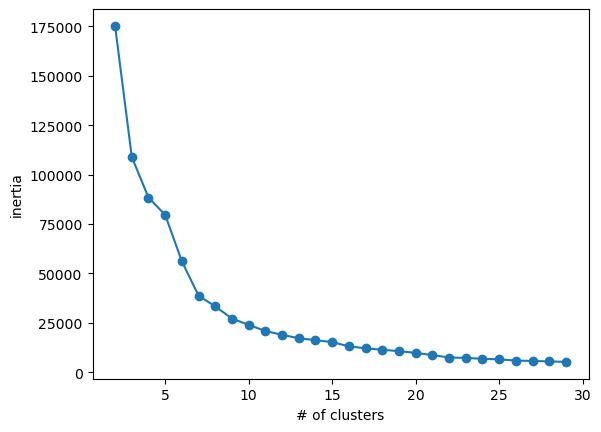

In [27]:
plt.plot(range(2,max_cluster),inertia, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('inertia')

In [28]:
kmeans = KMeans(init="k-means++",n_clusters=7, random_state=0).fit(user_info[cluster_vars])

In [35]:
filename = '../../../model_objects/geo_encoding.pkl'
with open(filename, 'wb') as file:
    pickle.dump(kmeans, file)